In [1]:
import numpy as np
from scipy.special import softmax
from hypertraps import HyperTraPS
from hypertraps_test import make_test_data_1, make_test_data_2
from hypertraps_test import (
    make_zeros_logits, make_left_right_logits, make_left_right_right_left_logits
)

In [2]:
# Set-up data
length = 7
mu = 10
sigma = 0.05
repeats = 1

# Simple example cases to illustrate calculation
X = make_test_data_1(length=length, repeats=repeats)
# Use zeros as parameters
logits = np.zeros((length, length))
hypertraps = HyperTraPS(logits, n_samples=1000)
print(f"{'Test dataset 1 with zero-order, log_prob:':60} {hypertraps.log_prob(X).sum():>8.3f}")

# Left-right data
X = make_test_data_1(length=length, repeats=repeats)
# Use directed walk as parameters
logits = make_left_right_logits(length)
hypertraps = HyperTraPS(logits, n_samples=1000)
print(f"{'Test dataset 1 with max likelihood logits, log_prob:':60} {hypertraps.log_prob(X).sum():>8.3f}")

# Left-right, right-left data
X = make_test_data_2(length=length, repeats=repeats)
# Use zeros as parameters
logits = np.zeros((length, length))
hypertraps = HyperTraPS(logits, n_samples=1000)
print(f"{'Test dataset 2 with zero-order, log_prob:':60} {hypertraps.log_prob(X).sum():>8.3f}")

# Left-right, right-left data
X = make_test_data_2(length=length, repeats=repeats)
# Use directed walk as parameters, 50-50
logits = make_left_right_right_left_logits(length)
hypertraps = HyperTraPS(logits, n_samples=1000)
print(f"{'Test dataset 2 with max likelihood logits, log_prob:':60} {hypertraps.log_prob(X).sum():>8.3f}")

Test dataset 1 with zero-order, log_prob:                     -17.092
Test dataset 1 with max likelihood logits, log_prob:           -0.000
Test dataset 2 with zero-order, log_prob:                     -34.183
Test dataset 2 with max likelihood logits, log_prob:           -8.318


In [3]:
%%time
# Run simple MCMC on HyerpTraPS
X = make_test_data_2(length=length, repeats=repeats)

#
hypertraps = HyperTraPS(make_zeros_logits(length), n_samples=20)

n_epochs = 50000
print_every = 1000
current_log_prob = hypertraps.log_prob(X).sum()
chain_log_probs, chain_logits = [], []
for epoch in range(n_epochs):
    mu = np.random.normal(loc=0., scale=sigma, size=hypertraps.logits.shape)
    old_logits = hypertraps.logits.copy()
    hypertraps.logits = np.clip(hypertraps.logits + mu, *hypertraps.params_range)
    update_log_prob = hypertraps.log_prob(X).sum()
    
    if (update_log_prob - current_log_prob) > np.log(np.random.uniform(0, 1)):
        current_log_prob = update_log_prob
    else:
        hypertraps.logits = old_logits
    
    if epoch % print_every == 0:
        print(f"Epoch: {epoch:>6.0f}, log prob: {current_log_prob:>8.1f}")
    
    chain_logits.append(hypertraps.logits)
    chain_log_probs.append(current_log_prob)
chain_log_probs = np.array(chain_log_probs)
chain_logits = np.array(chain_logits).squeeze()


Epoch:      0, log prob:    -34.6
Epoch:   1000, log prob:    -30.4
Epoch:   2000, log prob:    -22.8
Epoch:   3000, log prob:    -17.7
Epoch:   4000, log prob:    -18.2
Epoch:   5000, log prob:    -15.5
Epoch:   6000, log prob:    -14.8
Epoch:   7000, log prob:    -15.7
Epoch:   8000, log prob:    -13.8
Epoch:   9000, log prob:    -16.0
Epoch:  10000, log prob:    -13.2
Epoch:  11000, log prob:    -16.1
Epoch:  12000, log prob:    -15.0
Epoch:  13000, log prob:    -14.0
Epoch:  14000, log prob:    -20.3
Epoch:  15000, log prob:    -10.8
Epoch:  16000, log prob:    -13.0
Epoch:  17000, log prob:    -11.7
Epoch:  18000, log prob:    -15.2
Epoch:  19000, log prob:    -12.6
Epoch:  20000, log prob:    -11.4
Epoch:  21000, log prob:    -16.7
Epoch:  22000, log prob:    -13.8
Epoch:  23000, log prob:    -12.4
Epoch:  24000, log prob:    -17.1
Epoch:  25000, log prob:    -14.7
Epoch:  26000, log prob:    -14.7
Epoch:  27000, log prob:    -11.5
Epoch:  28000, log prob:    -18.5
Epoch:  29000,

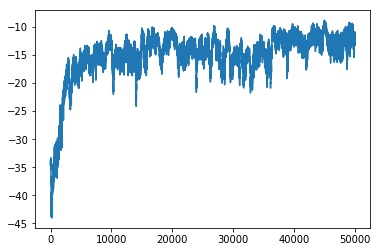

In [5]:
import matplotlib.pyplot as plt
# There is a problem as it is step-like, should have noise
plt.plot(chain_log_probs)
plt.show()